# Stanford CME 241 (Winter 2024) - Assignment 4

**Due: Feb 5 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 

-Handi Zhao(hdzhao@stanford.edu);

-Sylvia Sun(ys3835@stanford.edu);

-Zhengji Yang(yangzj@stanford.edu)

## Imports

In [3]:
from matplotlib import pyplot as plt
from rl.approximate_dynamic_programming import (
    value_iteration,
    approximate_policy_iteration
)

from rl.function_approx import Tabular
from rl.markov_decision_process import FiniteMarkovDecisionProcess, StateActionMapping
from numpy import allclose
from rl.distribution import Choose
import numpy as np
from typing import Mapping, Iterable, Tuple, Dict
from rl.distribution import Categorical, Choose
from rl.markov_decision_process import FiniteMarkovDecisionProcess, StateActionMapping

from dataclasses import dataclass, field, replace
from rl.dynamic_programming import policy_iteration, value_iteration_result
from rl.function_approx import FunctionApprox, Tabular
from dataclasses import dataclass
from itertools import islice

## Question 1
Implement *Approximate Policy Iteration*, generalization of the tabular
Policy Iteration we covered in the previous class. In order to implement
Approximate Policy Iteration, first review the interface and
implementation of *Approximate Policy Evaluation* and *Approximate Value
Iteration* (in file
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py)),
then design the interface of *Approximate Policy Iteration* to be the
same as that of *Approximate Value Iteration*. Note that your
implementation of *Approximate Policy Iteration* would need to invoke
*Approximate Policy Evaluation* since Policy Evaluation is a component
of Policy Iteration. Test that your implementation is correct in two
ways:

-   Ensure that *Approximate Policy Iteration* gives the same Optimal
    Value Function/Optimal Policy as that obtained by *Approximate Value
    Iteration*.

-   Ensure that *Approximate Policy Iteration* produces the same result
    as our prior implementation of Policy Iteration (in file
    [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
    For this you need to pass to your implementation of *Approximate
    Policy Iteration* a `FiniteMarkovDecisionProcess` input and a
    `Tabular` instance for the `FunctionApprox` input.

In [ ]:
def approximate_policy_iteration(
    mdp: MarkovDecisionProcess[S, A],
    gamma: float,
    approx_0: ValueFunctionApprox[S],
    non_terminal_states_distribution: NTStateDistribution[S],
    num_state_samples: int,
    num_iterations: int
) -> Iterator[Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]]:
    """
    Approximate Policy Iteration function.

    Parameters:
    mdp: MarkovDecisionProcess[S, A] - The given Markov Decision Process.
    gamma: float - Discount factor.
    approx_0: ValueFunctionApprox[S] - Initial value function approximation.
    non_terminal_states_distribution: NTStateDistribution[S] - Distribution of non-terminal states.
    num_state_samples: int - Number of state samples for approximation calculation.
    num_iterations: int - Number of iterations.

    Returns:
    Iterator[Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]] - Iterator of value function approximations and policies.
    """
    value_function = approx_0
    policy = DeterministicPolicy(lambda s: np.random.choice(mdp.actions(NonTerminal(s))))

    for _ in range(num_iterations):
        # Approximate Policy Evaluation
        value_function = evaluate_mrp(
            mdp.apply_policy(policy),
            gamma,
            value_function,
            non_terminal_states_distribution,
            num_state_samples
        ).__next__()

        # Policy Improvement
        def action_for_state(s: NonTerminal[S]) -> A:
            return max(
                ((mdp.step(s, a).expectation(lambda s_r: s_r[1] + gamma * extended_vf(value_function, s_r[0])), a)
                 for a in mdp.actions(s)),
                key=itemgetter(0)
            )[1]

        policy = DeterministicPolicy(action_for_state)

        yield (value_function, policy)


### Test1: Verify that Approximate Policy Iteration gives results as that obtained by Approximate Value Iteration.

In [ ]:
# design a simple mdp for testing
class SimpleGamblingMDP(FiniteMarkovDecisionProcess[int, int]):
    def __init__(self, max_capital: int, win_prob: float):
        """
        Initialize the Simple Gambling MDP.

        Parameters:
        max_capital (int): The maximum capital.
        win_prob (float): Probability of winning a bet.
        """
        self.max_capital = max_capital
        self.win_prob = win_prob
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> StateActionMapping[int, int]:
        """
        Get the action transition reward map for the MDP.

        Returns:
        StateActionMapping[int, int]: The action transition reward mapping.
        """
        d: Dict[int, Dict[int, Categorical[Tuple[int, float]]]] = {}
        for capital in range(1, self.max_capital):
            action_dict: Dict[int, Categorical[Tuple[int, float]]] = {}
            for bet in range(1, min(capital, self.max_capital - capital) + 1):
                outcomes = {
                    (capital + bet, bet): self.win_prob,  # Winning outcome
                    (capital - bet, -bet): 1 - self.win_prob  # Losing outcome
                }
                action_dict[bet] = Categorical(outcomes)
            d[capital] = action_dict
        return d


max_capital = 100
win_prob = 0.5
gamma = 0.9

# Creating an instance of MDP
gambling_mdp = SimpleGamblingMDP(max_capital=max_capital, win_prob=win_prob)

initial_values = {s: 0.0 for s in range(1, max_capital)}
approx_0 = Tabular(values_map=initial_values, count_to_weight_func=lambda n: 1.0 / n)

# Approximate value iteration
value_function_approx = value_iteration(
    mdp=gambling_mdp,
    γ=gamma,
    approx_0=approx_0,
    non_terminal_states_distribution=Choose(range(1, max_capital)),
    num_state_samples=1000
).__next__()

# Approximate policy iteration
policy_iteration_result = approximate_policy_iteration(
    mdp=gambling_mdp,
    gamma=gamma,
    approx_0=approx_0,
    non_terminal_states_distribution=Choose(range(1, max_capital)),
    num_state_samples=1000,
    num_iterations=100
).__next__()

# Check if value functions from both methods are close enough
tolerance = 1e-5
similar = all(
    abs(value_function_approx.values_map[s] - policy_iteration_result[0].values_map.get(s, 0)) <= tolerance
    for s in value_function_approx.values_map
)
print(f"Similar Value Functions: {similar}")


Similar Value Functions: True


### Test2: Ensure that Approximate Policy Iteration produces the same results as our prior implementation of Policy Iteration

In [ ]:
# Test code
max_capital = 100
win_prob = 0.5
gamma = 1.0
tolerance = 0.001

gambling_mdp = SimpleGamblingMDP(max_capital=max_capital, win_prob=win_prob)

# Use policy_iteration function
policy_iter_result = policy_iteration(gambling_mdp, gamma)

# Retrieve the final value function and policy
optimal_value_function, optimal_policy = next(islice(policy_iter_result, 100, None))

# Retrieve the final results from approximate policy iteration
approximate_value_function = policy_iteration_result[0].values_map

#function to test whether two output are close
def within_tolerance(v1: Dict[int, float], v2: Dict[int, float], tolerance: float) -> bool:
    return all(abs(v1[s] - v2.get(s, 0.0)) <= tolerance for s in v1)
# Check if the optimal and approximate value functions are close enough
are_close = within_tolerance(optimal_value_function, approximate_value_function, tolerance)
print(f"Are the value functions close enough (tolerance {tolerance})? {'Yes' if are_close else 'No'}")


Are the value functions close enough (tolerance 0.001)? Yes


## Question 2
Assume the Utility function is $U(x) = x - \frac {\alpha x^2} 2$.
Assuming $x \sim \mathcal{N}(\mu, \sigma^2)$, calculate:

-   Expected Utility $\mathbb{E}[U(x)]$

-   Certainty-Equivalent Value $x_{CE}$

-   Absolute Risk-Premium $\pi_A$


Assume you have a million dollars to invest for a year and you are
allowed to invest $z$ dollars in a risky asset whose annual return on
investment is $\mathcal{N}(\mu, \sigma^2)$ and the remaining (a million
minus $z$ dollars) would need to be invested in a riskless asset with
fixed annual return on investment of $r$. You are not allowed to adjust
the quantities invested in the risky and riskless assets after your
initial investment decision at time $t=0$ (static asset allocation
problem). If your risk-aversion is based on this Utility function, how
much would you invest in the risky asset? In other words, what is the
optimal value for $z$, given your level of risk-aversion (determined by
a fixed value of $\alpha$)?

Plot how the optimal value of $z$ varies with $\alpha$.

 1). Expected Utility: 
 
 \begin{align}
 \mathbb{E}[U(x)] & = \mathbb{E}[x] - \dfrac{\alpha}{2} \mathbb{E}[x^2] \\
                  & = \mathbb{E}[x] - \dfrac{\alpha}{2} (\text{Var}[x] + \mathbb{E}[x]^2)\\
                  & = \mu - \dfrac{\alpha}{2}(\sigma^2 + \mu^2) 
 \end{align}

 2). Certainty-Equivalent Value:

 \begin{align}
 x_{CE} &= U^{-1}(\mathbb{E}[U(x)]) \\
        &= \dfrac{1 \pm \sqrt{1 - 2\alpha\mathbb{E}[U(x)]}}{\alpha} \\
        &= \dfrac{1 \pm \sqrt{\alpha^2\sigma^2 + (\alpha\mu - 1)^2}}{\alpha}
 \end{align}

 3). Absolute Risk-Premium:

 \begin{align}
\pi_A &= \mathbb{E}[x] - x_{CE}\\
      &= \mu - \dfrac{1 \pm \sqrt{\alpha^2\sigma^2 + (\alpha\mu - 1)^2}}{\alpha}\\
      &= \dfrac{\alpha\mu - 1 \pm \sqrt{\alpha^2\sigma^2 + (\alpha\mu - 1)^2}}{\alpha}
 \end{align}

For the situation of investing $z$ dollars in risky asset, $1M - z$ dollars in rates, the synthetic portfolio has a return of $$X_z \sim \mathcal{N}(z\mu + (1M - z)r, z^2\sigma^2).$$

From the expression of expected utility of a Gaussian R.V., we get
\begin{align}
\mathbb{E}[U(X_z)] &= z\mu + (1M - z)r - \dfrac{\alpha}{2}(z^2\sigma^2 + (z\mu + (1M - z)r)^2)\\
                 &= (\mu - r)z + 1M \cdot r - \dfrac{\alpha}{2}[\sigma^2 + (\mu-r)^2]z^2 - \dfrac{\alpha}{2}2(1M\cdot r) \cdot (\mu - r)z + \dfrac{\alpha}{2}(1M\cdot r)^2\\
                 &= -\dfrac{\alpha[\sigma^2 + (\mu-r)^2]}{2}z^2 + [1 - \alpha(1M\cdot r)](\mu - r)z + 1M \cdot r 
                 + \dfrac{\alpha}{2}(1M\cdot r)^2\\
\end{align}

Thus, if the risk-aversion is perfectly measured by certainty equivalent value $x_{CE}$ with parameter $\alpha$, the optimal value is given by
\begin{align}
z^* &= \text{argmax}_z\,\, U^{-1}(\mathbb{E}[U(X_z)])\\
    &= \text{argmax}_z\,\, \dfrac{1 \pm \sqrt{\alpha^2\sigma^2 z^2 + (\alpha\cdot 1M\cdot r + \alpha (\mu - r) z - 1)^2}}{\alpha}\\
    &= \text{argmax}_{z}\,\, \alpha^2[\sigma^2 + (\mu-r)^2] z^2 - 2\alpha[1 - \alpha(1M\cdot r)](\mu - r)z + [1 - \alpha(1M\cdot r)]^2\\
    &= \left\{
        \begin{aligned}
        &0,\quad  & & \dfrac{[1 - \alpha(1M\cdot r)](\mu - r)}{\alpha[\sigma^2 + (\mu-r)^2]} \geq 0.5M\\
        &1M,\quad & & o.w.
        \end{aligned}
        \right.\\
    &= \left\{
        \begin{aligned}
        &0,\quad  & & \alpha \geq \dfrac{2(\mu - r)*10^{-6}}{\sigma^2 + \mu^2 - r^2}\\
        &1M,\quad & & o.w.
        \end{aligned}
        \right.\\
\end{align}

In [4]:
import numpy as np
from matplotlib import pyplot as plt

Text(0, 0.5, 'optimal value for z')

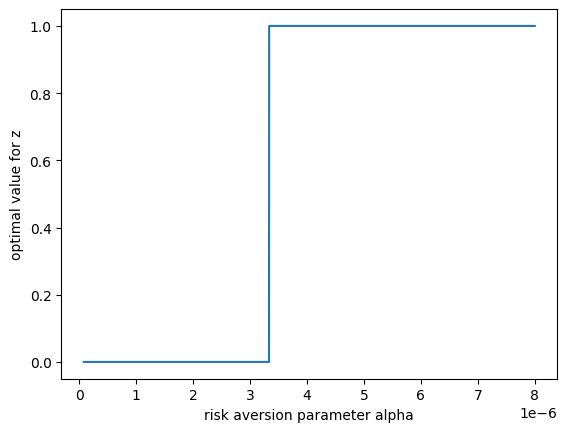

In [18]:
mu = 0.1
r = 0.05
sigma = 0.15
alpha0 = 0.4/(1e6*r)
alpha = np.linspace(alpha0/100, alpha0, 10000)
z = ((1 - alpha*1e6*r)*(mu - r)/(alpha * (sigma**2 + (mu-r)**2)) < 5e5)
plt.plot(alpha,z)
plt.xlabel('risk aversion parameter alpha')
plt.ylabel('optimal value for z')

## Question 3

Assume you are playing a casino game where at every turn, if you bet a
quantity $x$, you will be returned $x \cdot (1 + \alpha)$ with
probability $p$ and returned $x \cdot (1 - \beta)$ with probability
$q = 1 - p$ for $\alpha, \beta \in \mathbb{R}^+$ (i.e., the return on
bet is $\alpha$ with probability $p$ and $-\beta$ with probability
$q = 1-p$) . The problem is to identify a betting strategy that will
maximize one's expected wealth over the long run. The optimal solution
to this problem is known as the Kelly criterion, which involves betting
a constant fraction of one's wealth at each turn (let us denote this
optimal fraction as $f^*$).

It is known that the Kelly criterion (formula for $f^*$) is equivalent
to maximizing the Expected Utility of Wealth after a single bet, with
the Utility function defined as: $U(W) = \log(W)$. Denote your wealth
before placing the single bet as $W_0$. Let $f$ be the fraction (to be
solved for) of $W_0$ that you will bet. Therefore, your bet is
$f \cdot W_0$.

-   Write down the two outcomes for wealth $W$ at the end of your single
    bet of $f \cdot W_0$.

-   Write down the two outcomes for $\log$ (Utility) of $W$.

-   Write down $\mathbb{E}[\log(W)]$.

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

-   Set this derivative to 0 to solve for $f^*$. Verify that this is
    indeed a maxima by evaluating the second derivative at $f^*$. This
    formula for $f^*$ is known as the Kelly Criterion.

-   Convince yourself that this formula for $f^*$ makes intuitive sense
    (in terms of it's dependency on $\alpha$, $\beta$ and $p$).


## Question 4

Derive the solution to Merton's Portfolio problem for the case of the
$\log(\cdot)$ Utility function. Note that the derivation in the textbook
is for CRRA Utility function with $\gamma \neq 1$ and the case of the
$\log(\cdot)$ Utility function was left as an exercise to the reader.

We denote the fraction of wealth allocated to the risky asset at time $t$ as $ \pi (t, W_t)$ and the fraction of wealth allocated to the riskless asset at time $t$ is $1 - \pi (t, W_t)$. The infinitesimal change in wealth $dW_t$ from time $t$ to time $t + dt$ is given by: $$dW_t = ((r+\pi_t \cdot (\mu - r))·W_t - c_t) \cdot dt+\pi_t \cdot \sigma \cdot W_t \cdot dz_t$$
    The goal is to determine optimal $\pi(t, W_t), c(t, W_t)$ at any time $t$ to maximize: $$\mathbb{E}[\int_t^T e^{- \rho(s-t)} \cdot \log(c_s) \cdot ds + e^{- \rho(T-t)} \cdot B(T) \cdot \log(W_T) | W_t]$$ where $B(T)$ is the bequest and take $B(T) = 1/\rho$ for simplicity.
    The Hamilton-Jacobi-Bellman equation is then $$\max_{\pi_t,c_t} \{ \mathbb{E}_t [dV^*(t, W_t)] + \log(c_t) \cdot dt\} = \rho \cdot V^*(t, W_t) \cdot dt$$ 
    Then, use Ito’s Lemma on $dV^*$, remove the $dz_t$ term, and divide throughout by $dt$ to get $$\max_{\pi_t,c_t} \{ \frac{\partial V^*}{\partial t}+\frac{\partial V^*}{\partial W_t} \cdot ((r+\pi_t \cdot (\mu - r))·W_t - c_t) + \frac{\partial^2 V^*}{\partial W_t^2} \cdot \frac{\pi_t^2 \cdot \sigma^2 \cdot W_t^2}{2} + \log(c_t)\} = \rho \cdot V^*(t, W_t)$$ with the terminal condition $$V^*(T, W_T) = \frac{1}{\rho}\log(W_T)$$
    Take partial derivative with respect to $\pi_t^*$, $c_t^*$ and equate to 0 to get $$(\mu-r) \cdot \frac{\partial V^*}{\partial W_t} + \frac{\partial^2 V^*}{\partial W_t^2} \cdot \pi_t \cdot \sigma^2 \cdot W_t = 0 \implies \pi_t^*=\frac{-\frac{\partial V^*}{\partial W_t} \cdot (\mu-r)}{\frac{\partial^2 V^*}{\partial W_t^2} \cdot \sigma^2 \cdot W_t}$$ 
    $$-\frac{\partial V^*}{\partial W_t} + \frac{1}{c_t^*} = 0 \implies c_t^* = \frac{\partial W_t}{\partial V^*}$$
    Substitute $\pi_t^*$ and $c_t^*$ back to get the Optimal Value Function Partial Differential Equation: $$\frac{\partial V^*}{\partial t}-\frac{(\mu-r)^2}{2\sigma^2} \cdot \frac{(\frac{\partial V^*}{\partial W_t})^2}{\frac{\partial^2 V^*}{\partial W_t^2}} + \frac{\partial V^*}{\partial W_t} \cdot r \cdot W_t + \log(\frac{\partial W_t}{\partial V^*}) - 1 = \rho \cdot V^*(t, W_t)$$
    We surmise with a guess solution in terms of a deterministic function (f) of time: $$V^*(t, W_t) = f(t) + \frac{1}{\rho}log(W_t)$$ then $$\frac{\partial V^*}{\partial t} = f'(t)$$ $$\frac{\partial V^*}{\partial W_t} = \frac{1}{\rho W_t}$$ $$\frac{\partial^2 V^*}{\partial W_t^2} = -\frac{1}{\rho W_t^2}$$
    In this case, $\displaystyle \pi_t^* (t, W_t)=\frac{\mu-r}{\sigma^2}$ and $c_t^* (t, W_t) = \rho W_t$ .
    Substituting the guess solution in the PDE, we get the simple ODE: $f'(t) - \rho f(t) + \nu = 0$ where $\displaystyle \nu=\frac{(\mu-r)^2}{2\rho \sigma^2}+\frac{r-\rho}{\rho} + log(\rho)$ with boundary condition $f(T)=0$. The solution of the ODE is then $$f(t)=\frac{\nu}{\rho} (1-e^{-\rho(T-t)})$$
    Substituting $f(t)$ into $V^*(t, W_t)$ to get $$V^*(t, W_t)=\frac{\nu}{\rho} (1-e^{-\rho(T-t)})+\frac{1}{\rho}log(W_t)$$